## General Observations

Datasets that are too imbalanced: 
- Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv 
- Friday-23-02-2018_TrafficForML_CICFlowMeter.csv 

Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv
- not very good label seperation, should check every csv to see which one has best seperation. 
- only got destination port

Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
- Seperation on Fwd PSH Flag 
- Pkt legnth is always left skewed
- only got destination port 

Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
- got both dest and src port, with dest and src IP, can use this to make a network? 
- looks like a lot of features have the exact same label wise trend tho

Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
- only got dest port 
- 3 labels should merge the 2 types of ddos attacks? 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values


## Basic Traffic Volume Analysis
- each row is a portion of a flow from source to destination IP. Each row can represent the summary of a certain number of packets.
- all the attack flows happen within a short time period, from the a few Source IPs on the same Destination IP

In [2]:
ddos2018_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2018_cleaned.csv')
ddos2017_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2017_cleaned.csv')
dos2017_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/dos2017_cleaned.csv')
botnet2017_df_cleaned = pd.read_csv('/Users/emmalim/Desktop/DSA4263/botnet2017_cleaned.csv')

In [7]:
dos2017_df_cleaned["Label"] = dos2017_df_cleaned["Label"].apply(lambda x: "DOS" if x != "BENIGN" else "BENIGN")
print(dos2017_df_cleaned['Label'].value_counts())
print(ddos2018_df_cleaned['Label'].value_counts())
print(ddos2017_df_cleaned['Label'].value_counts())
print(botnet2017_df_cleaned['Label'].value_counts())


Label
BENIGN    440031
DOS       252672
Name: count, dtype: int64
Label
Benign                    1343290
DDoS attacks-LOIC-HTTP     575394
Name: count, dtype: int64
Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64
Label
BENIGN    189067
Bot         1966
Name: count, dtype: int64


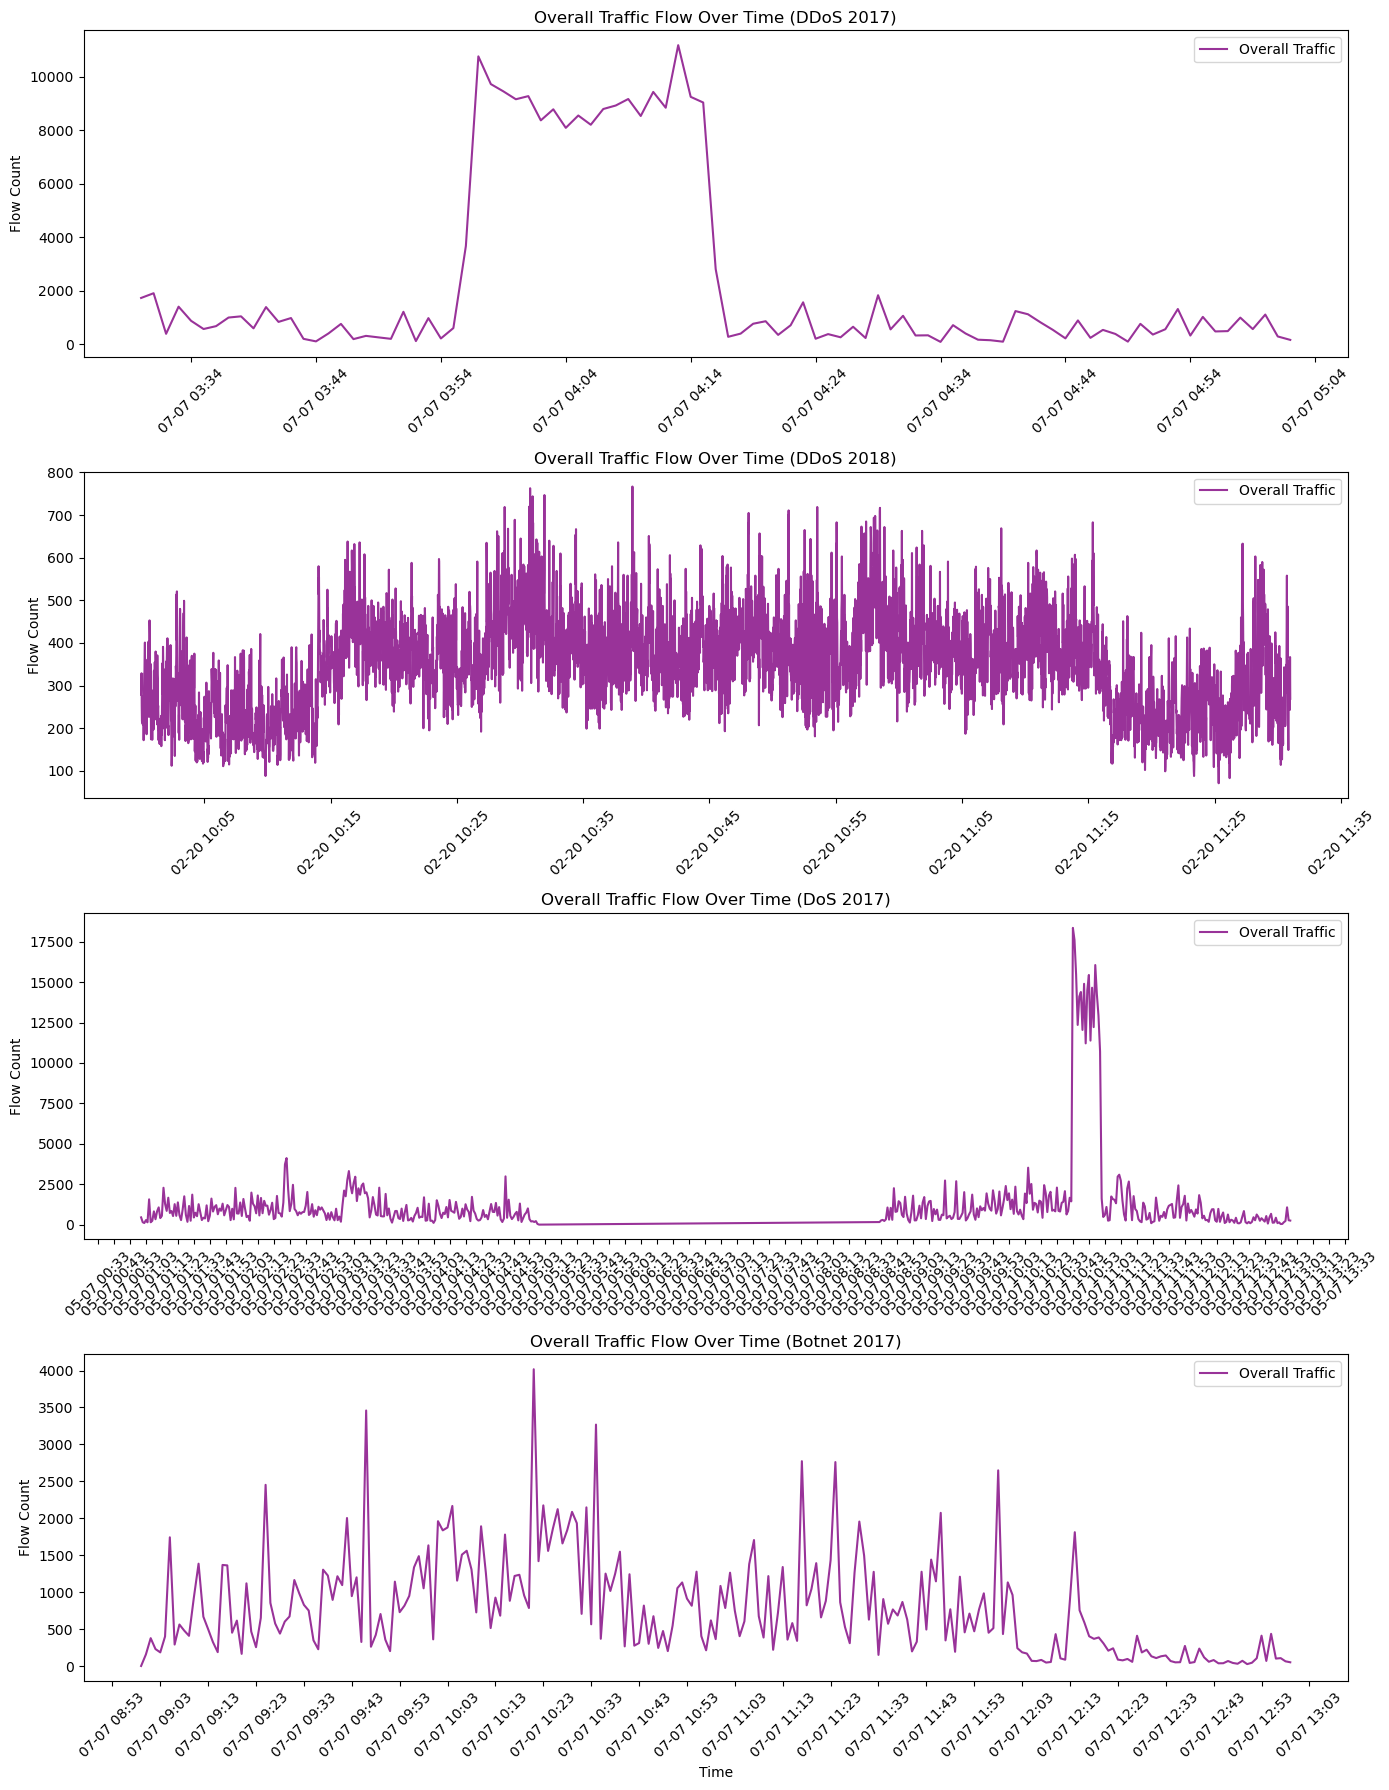

In [4]:
# List of datasets and titles
datasets = [
    (ddos2017_df_cleaned, "DDoS 2017"),
    (ddos2018_df_cleaned, "DDoS 2018"),
    (dos2017_df_cleaned, "DoS 2017"),
    (botnet2017_df_cleaned, "Botnet 2017")
]

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=False)

for i, (df, title) in enumerate(datasets):
    analysis_df = df.copy()
    analysis_df['Timestamp'] = pd.to_datetime(analysis_df['Timestamp'])
    analysis_df['Time_Seconds'] = analysis_df['Timestamp'].dt.floor('s')
    overall_traffic = analysis_df.groupby('Time_Seconds').size()

    axs[i].plot(overall_traffic.index, overall_traffic, label="Overall Traffic", color='purple', alpha=0.8)
    axs[i].set_title(f"Overall Traffic Flow Over Time ({title})")
    axs[i].set_ylabel("Flow Count")
    axs[i].legend()

    # Format time axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    axs[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    axs[i].tick_params(axis='x', rotation=45)

# Shared X label
plt.xlabel("Time")
plt.tight_layout()
plt.show()


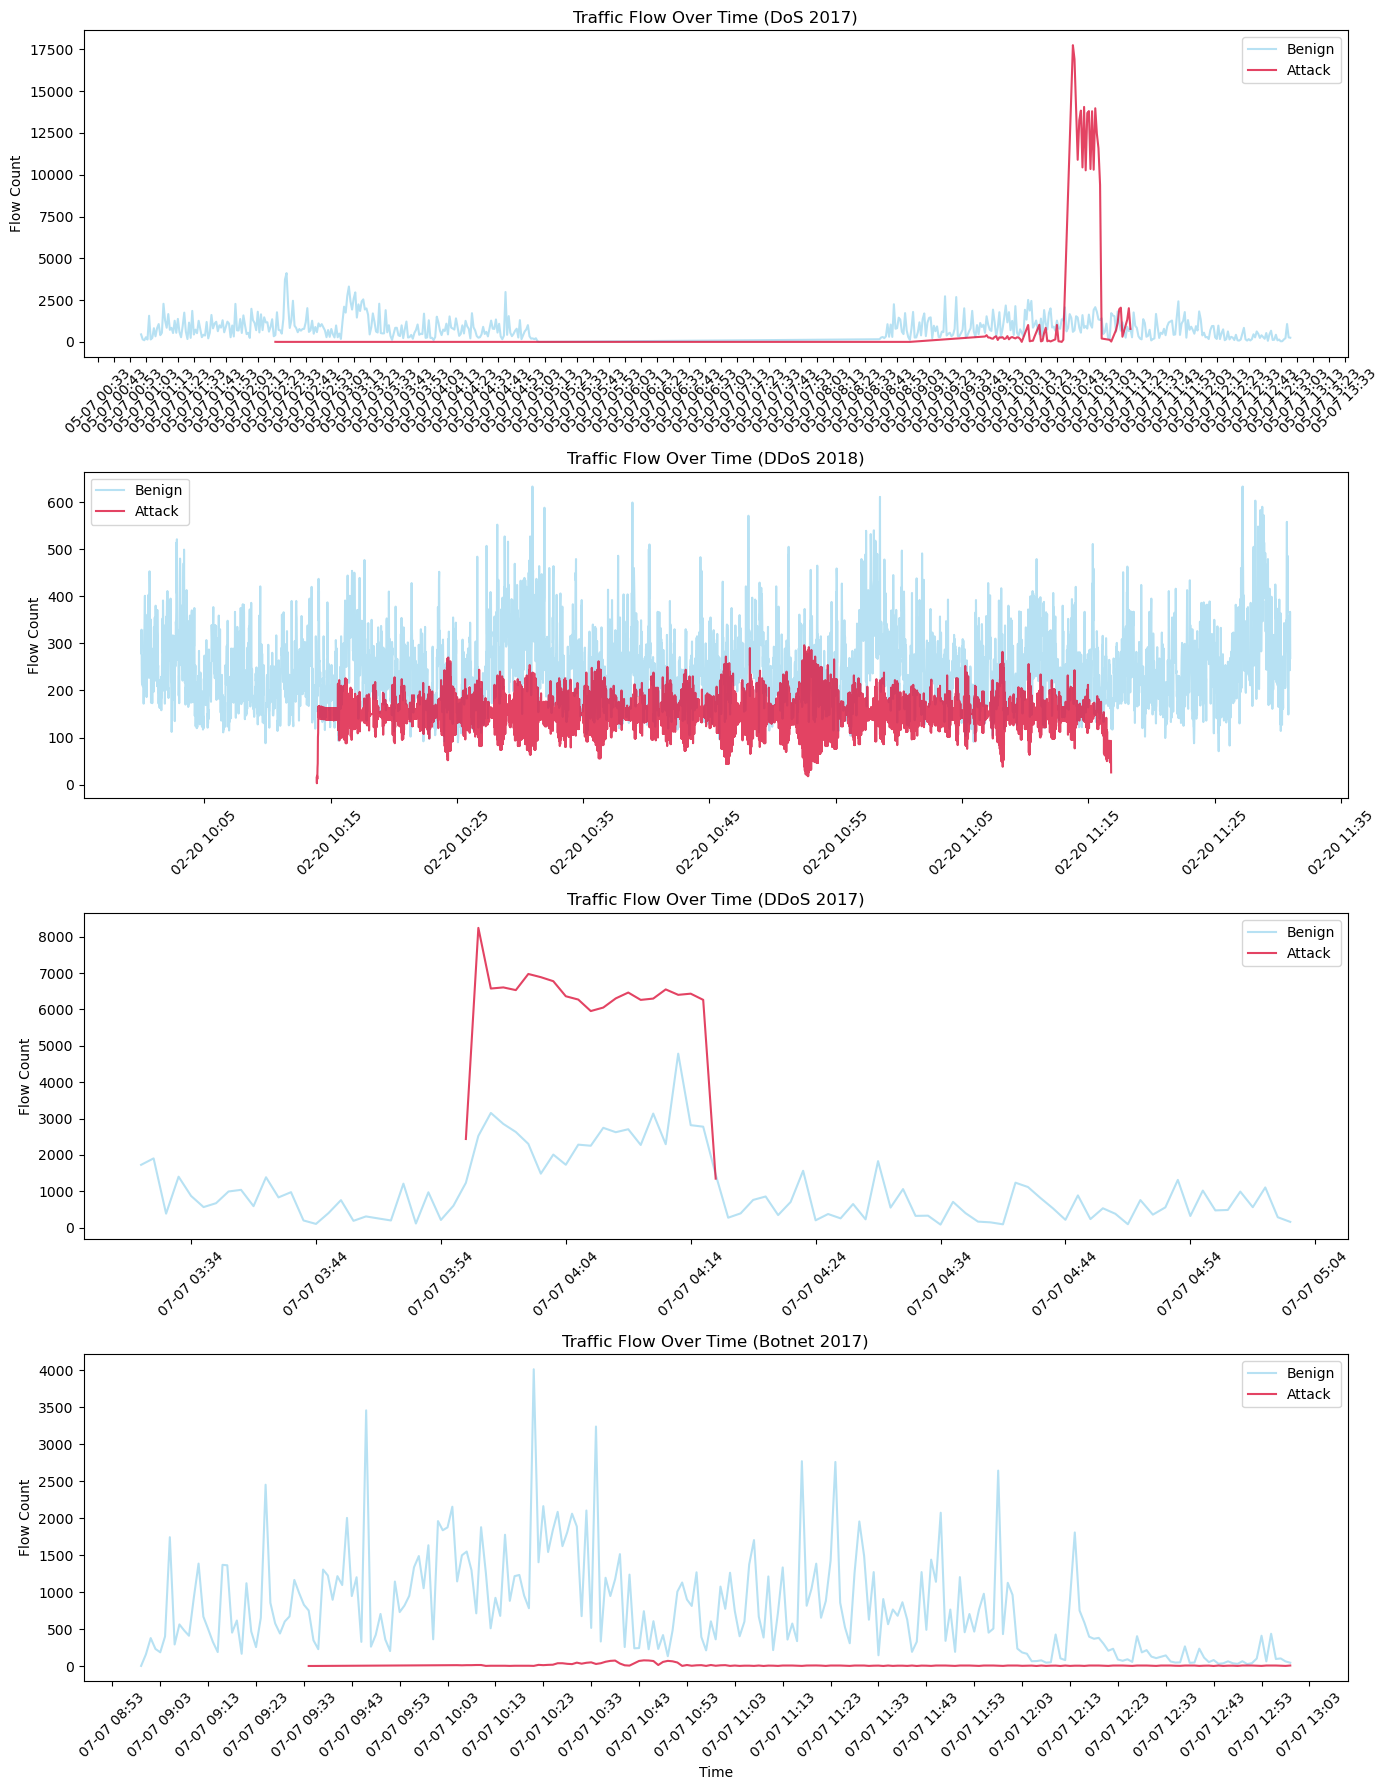

In [8]:
# Define dataset-label mappings
datasets = [
    (dos2017_df_cleaned, "DoS 2017", {'BENIGN': 'Benign', 'DOS': 'Attack'}),
    (ddos2018_df_cleaned, "DDoS 2018", {'Benign': 'Benign', 'DDoS attacks-LOIC-HTTP': 'Attack'}),
    (ddos2017_df_cleaned, "DDoS 2017", {'BENIGN': 'Benign', 'DDoS': 'Attack'}),
    (botnet2017_df_cleaned, "Botnet 2017", {'BENIGN': 'Benign', 'Bot': 'Attack'})
]

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=False)

# Loop through each dataset
for i, (df, title, label_map) in enumerate(datasets):
    df_copy = df.copy()
    df_copy['Timestamp'] = pd.to_datetime(df_copy['Timestamp'])
    df_copy['Label'] = df_copy['Label'].map(label_map)  # Normalize labels
    df_copy['Time_Seconds'] = df_copy['Timestamp'].dt.floor('s')

    # Group by time
    benign_traffic = df_copy[df_copy['Label'] == 'Benign'].groupby('Time_Seconds').size()
    attack_traffic = df_copy[df_copy['Label'] == 'Attack'].groupby('Time_Seconds').size()

    # Plot both
    axs[i].plot(benign_traffic.index, benign_traffic, label="Benign", color='skyblue', alpha=0.6)
    axs[i].plot(attack_traffic.index, attack_traffic, label="Attack", color='crimson', alpha=0.8)
    axs[i].set_title(f"Traffic Flow Over Time ({title})")
    axs[i].set_ylabel("Flow Count")
    axs[i].legend()

    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    axs[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    axs[i].tick_params(axis='x', rotation=45)

plt.xlabel("Time")
plt.tight_layout()
plt.show()


## Analyse expected positive relationships
* Flow duration: DoS/DDoS attacks often prolonged high-volume traffic or very short, intense bursts. 
* DDoS Attacks: In DDoS attacks, the inter-arrival time between packets might be very short (indicating that many packets are being sent in a short period of time), which can cause network congestion. Normal Traffic: For normal traffic, the inter-arrival time is typically more spread out, as packets are often sent with more regular intervals.
* We see quite a bit of similarity between features, such as in Fwd Packet characteristics. However, some differences in Packet Length Mean.

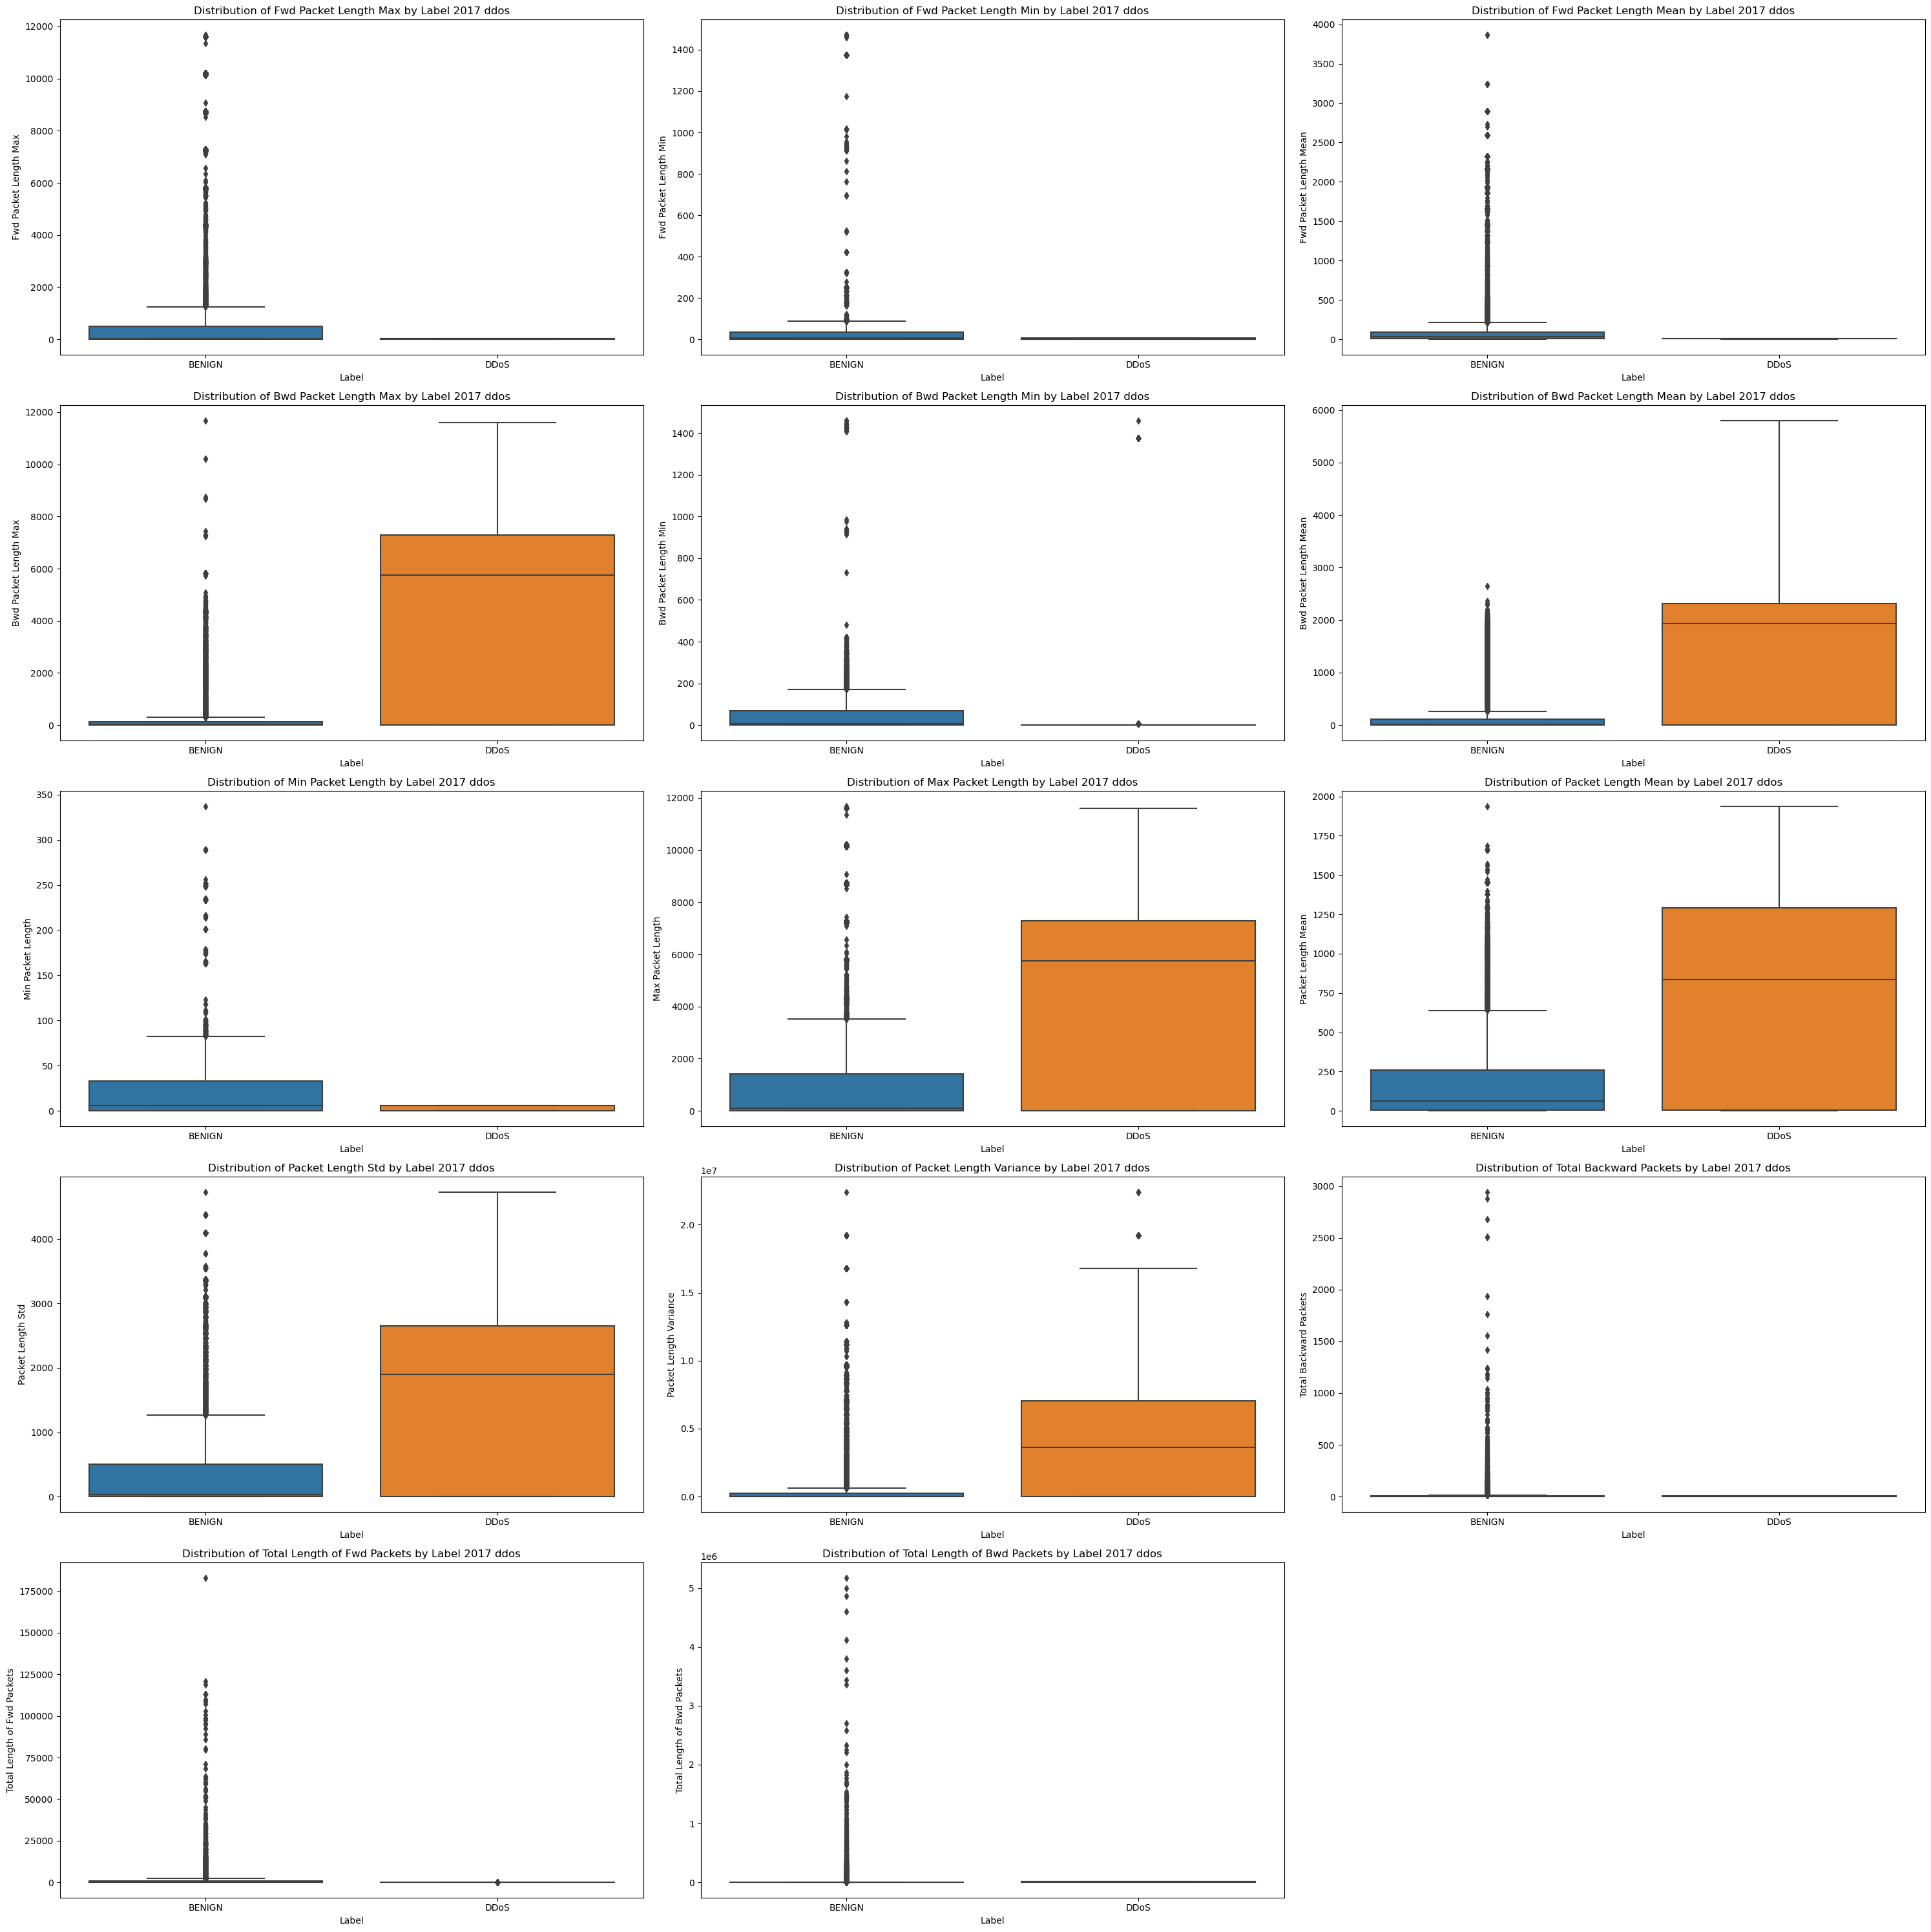

In [10]:
# List of packet size-related features
packet_size_features = [
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets'
]

# Visualizing packet size distributions for both Benign and DDoS traffic
plt.figure(figsize=(30, 30))
for i, feature in enumerate(packet_size_features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='Label', y=feature, data=ddos2017_df_cleaned)
    plt.title(f'Distribution of {feature} by Label 2017 ddos')
plt.tight_layout()
plt.show()

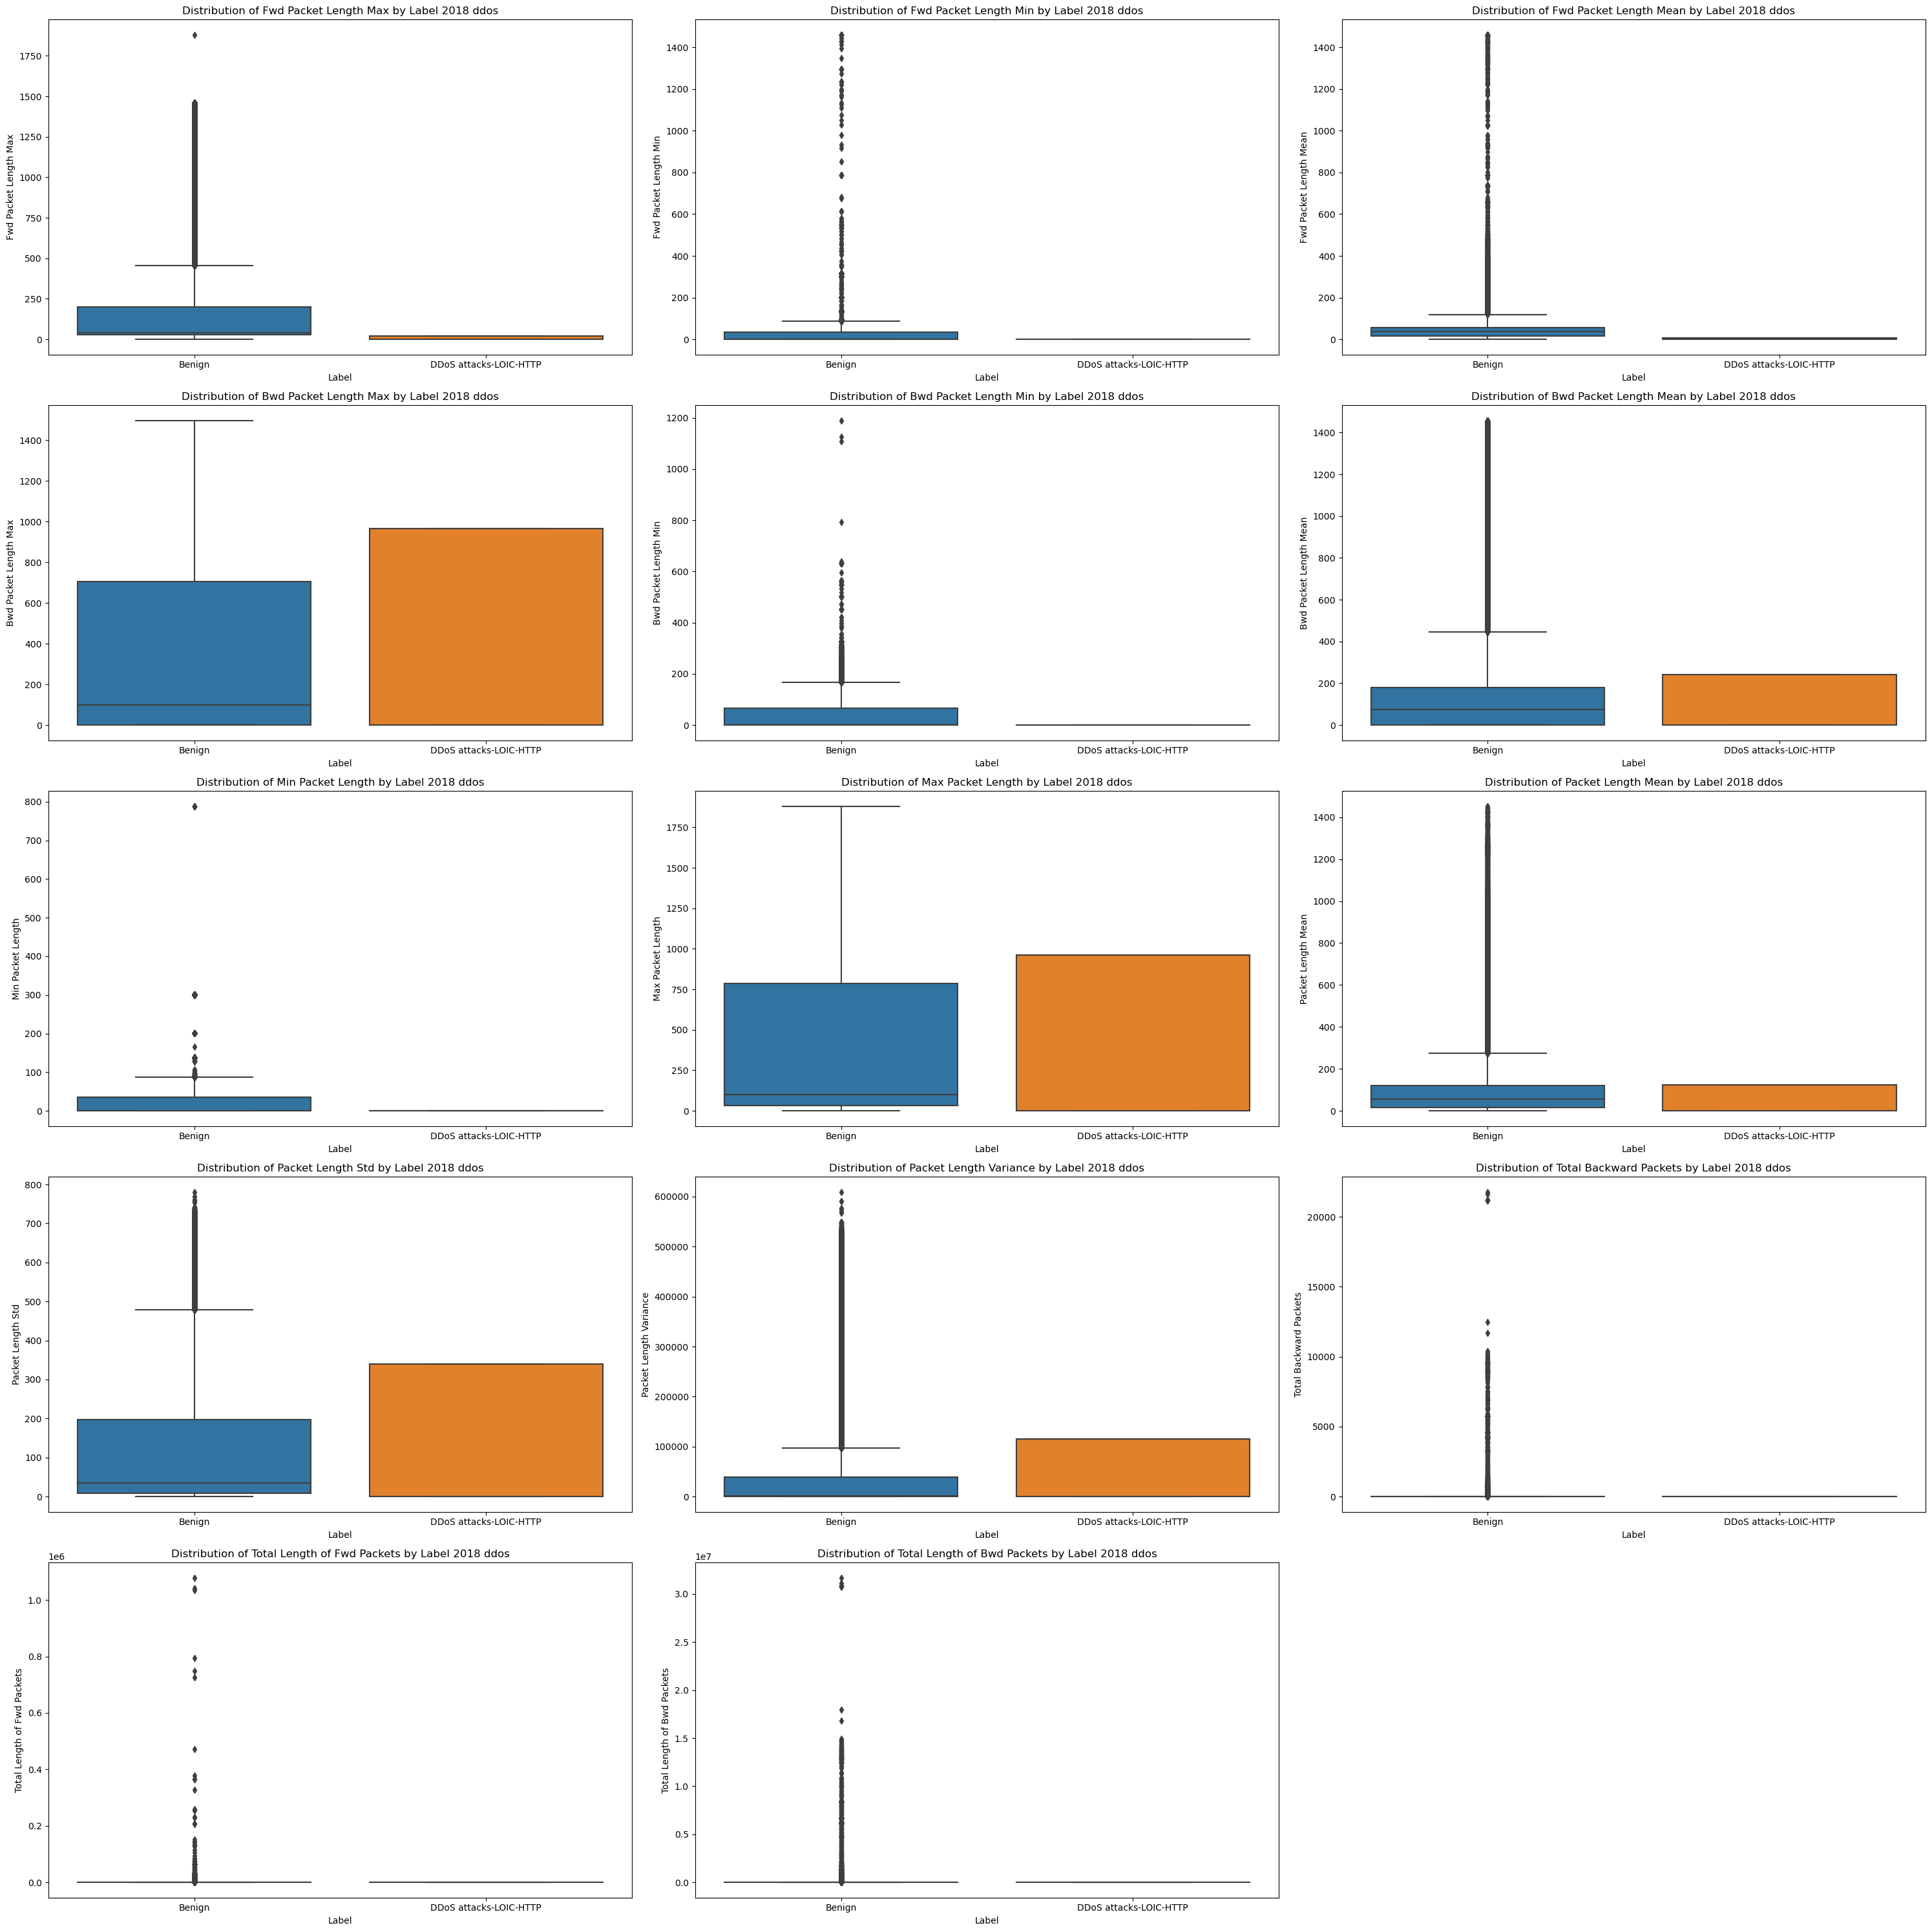

In [11]:
# List of packet size-related features
packet_size_features = [
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets'
]

# Visualizing packet size distributions for both Benign and DDoS traffic
plt.figure(figsize=(30, 30))
for i, feature in enumerate(packet_size_features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='Label', y=feature, data=ddos2018_df_cleaned)
    plt.title(f'Distribution of {feature} by Label 2018 ddos')
plt.tight_layout()
plt.show()

## Network Analysis 

- Edge Weight Distribution - if edge weight is count of flow ID between each src and dst ip, can try use average edge weights to identify DoS 
- Degree Centrality - high degree centrality = more edges connected to the node --> might be able to find source nodes that are being attacked. 
- DDOS Attack Network between the years show different patterns, furthermore, each csv only has 1 attack. This could hinder usefulness of graph structures in modelling. --> solution is to add in DOS and Botnet. increase generalisability, reduce overfitting to 2017 DDOS. 

### Statistical Analyis of Network (2018)
* statistically significant difference in graph metrics between labels

In [27]:
# Create a directed graph (assuming flow direction matters)
G = nx.DiGraph()
network_df = ddos2018_df_cleaned[['Source IP', 'Destination IP', 'Flow ID', 'Label']]
# Add weighted edges
for _, row in network_df.iterrows():
    src, dst = row["Source IP"], row["Destination IP"]
    
    if G.has_edge(src, dst):
        G[src][dst]['weight'] += 1  # Increase weight if edge exists
    else:
        G.add_edge(src, dst, weight=1, label=row["Label"])  # Add new edge with weight 1
        
        
node_labels = {}
for _, row in network_df.iterrows():
    src, dst, label = row["Source IP"], row["Destination IP"], row["Label"]
    
    # If node is already labeled "Attack", keep it
    if node_labels.get(src) != "DDoS attacks-LOIC-HTTP":
        node_labels[src] = label  # Assign attack or benign label
    if node_labels.get(dst) != "DDoS attacks-LOIC-HTTP":
        node_labels[dst] = label  # Destination might also be relevant

In [28]:
print(G)

DiGraph with 13848 nodes and 206692 edges


In [ ]:
# Compute graph metrics
degree_centrality = nx.degree_centrality(G)  # Unweighted
weighted_degree = {node: sum(data["weight"] for _, data in G[node].items()) for node in G}  # Weighted
pagerank = nx.pagerank(G, weight='weight')
betweenness = nx.betweenness_centrality(G, weight='weight')
k_core = nx.core_number(G)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame({
    "Node": list(G.nodes),
    "Degree Centrality": [degree_centrality[node] for node in G.nodes],
    "Weighted Degree": [weighted_degree.get(node, 0) for node in G.nodes],
    "PageRank": [pagerank[node] for node in G.nodes],
    "Betweenness": [betweenness[node] for node in G.nodes],
    "K-Core Number": [k_core[node] for node in G.nodes]
})

# Add attack/benign labels
metrics_df["Label"] = metrics_df["Node"].map(node_labels)



In [39]:
# Separate attack and benign nodes
attack_metrics = metrics_df[metrics_df["Label"] == "DDoS attacks-LOIC-HTTP"]
benign_metrics = metrics_df[metrics_df["Label"] == "Benign"]

/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/emmalim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

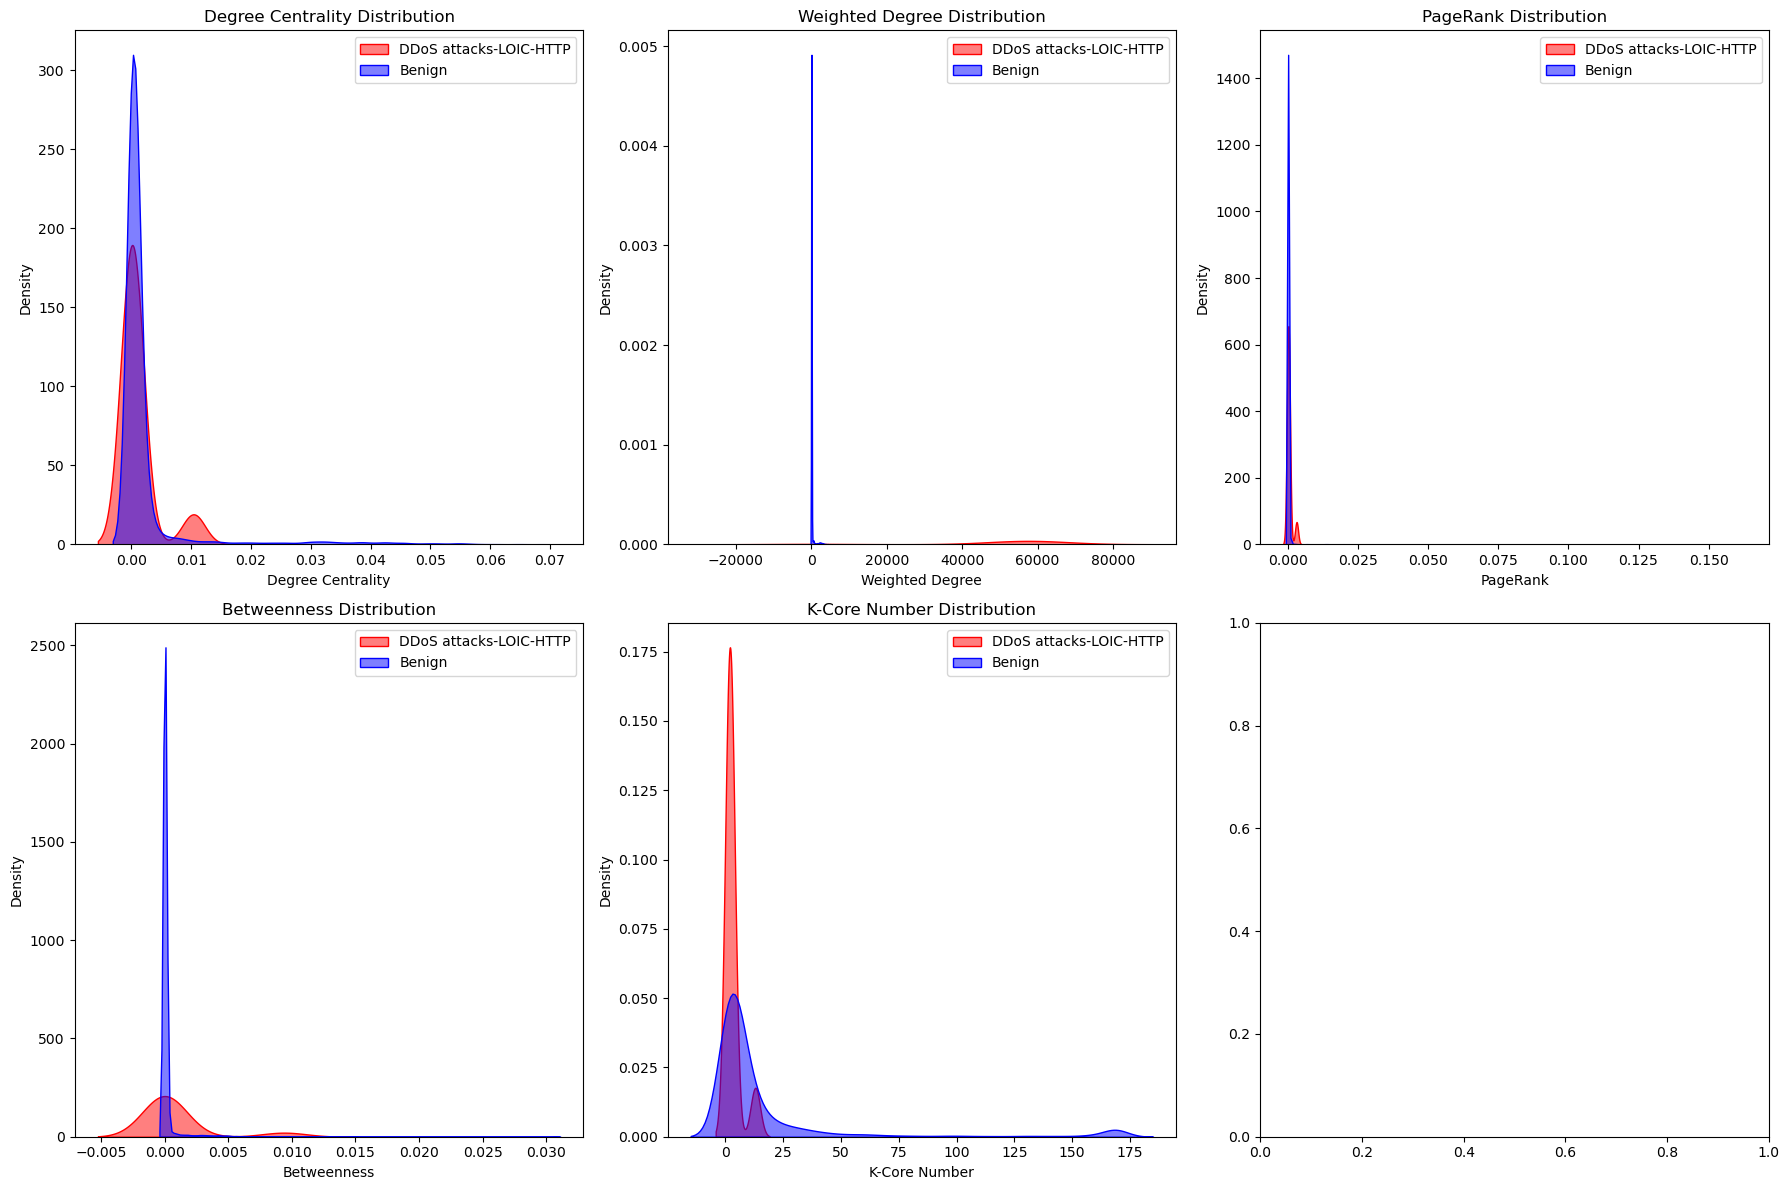

In [40]:
# Plot distributions for different metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ["Degree Centrality", "Weighted Degree", "PageRank", "Betweenness", "K-Core Number"]
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    sns.kdeplot(attack_metrics[metric], label="DDoS attacks-LOIC-HTTP", fill=True, color="red", alpha=0.5, ax=ax)
    sns.kdeplot(benign_metrics[metric], label="Benign", fill=True, color="blue", alpha=0.5, ax=ax)
    ax.set_title(f"{metric} Distribution")
    ax.legend()

plt.tight_layout()
plt.show()


In [44]:
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind

for metric in metrics:
    attack_values = attack_metrics[metric]
    benign_values = benign_metrics[metric]

    if len(attack_values) > 0 and len(benign_values) > 0:
        ks_stat, ks_p = ks_2samp(attack_values, benign_values)
        mw_stat, mw_p = mannwhitneyu(attack_values, benign_values, alternative='two-sided')
        t_stat, tt_p = ttest_ind(attack_values, benign_values)


        print(f"\n{metric}:")
        print(f"  Kolmogorov-Smirnov test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
        print(f"  Mann-Whitney U test: Statistic={mw_stat:.4f}, p-value={mw_p:.4f}")
        print(f"  T-test: Statistic={t_stat:.4f}, p-value={tt_p:.4f}")
    else:
        print(f"\nSkipping {metric}: One of the distributions is empty.")


Degree Centrality:
  Kolmogorov-Smirnov test: Statistic=0.4952, p-value=0.0052
  Mann-Whitney U test: Statistic=52096.0000, p-value=0.0667
  T-test: Statistic=-0.5015, p-value=0.6160

Weighted Degree:
  Kolmogorov-Smirnov test: Statistic=0.9462, p-value=0.0000
  Mann-Whitney U test: Statistic=151462.5000, p-value=0.0000
  T-test: Statistic=260.5858, p-value=0.0000

PageRank:
  Kolmogorov-Smirnov test: Statistic=0.9437, p-value=0.0000
  Mann-Whitney U test: Statistic=146731.0000, p-value=0.0000
  T-test: Statistic=0.8994, p-value=0.3684

Betweenness:
  Kolmogorov-Smirnov test: Statistic=0.2449, p-value=0.4533
  Mann-Whitney U test: Statistic=59776.0000, p-value=0.1428
  T-test: Statistic=2.3738, p-value=0.0176

K-Core Number:
  Kolmogorov-Smirnov test: Statistic=0.4952, p-value=0.0052
  Mann-Whitney U test: Statistic=49692.5000, p-value=0.0437
  T-test: Statistic=-1.2563, p-value=0.2090


### Visualisation of graph network
* benign activity is consistent throughout the years. 
* DDOS activity between 2017 and 2018 differs greatly, not only in quantity but in graph structure. 
* 2017 Botnet structure is the most similar to 2018 structure

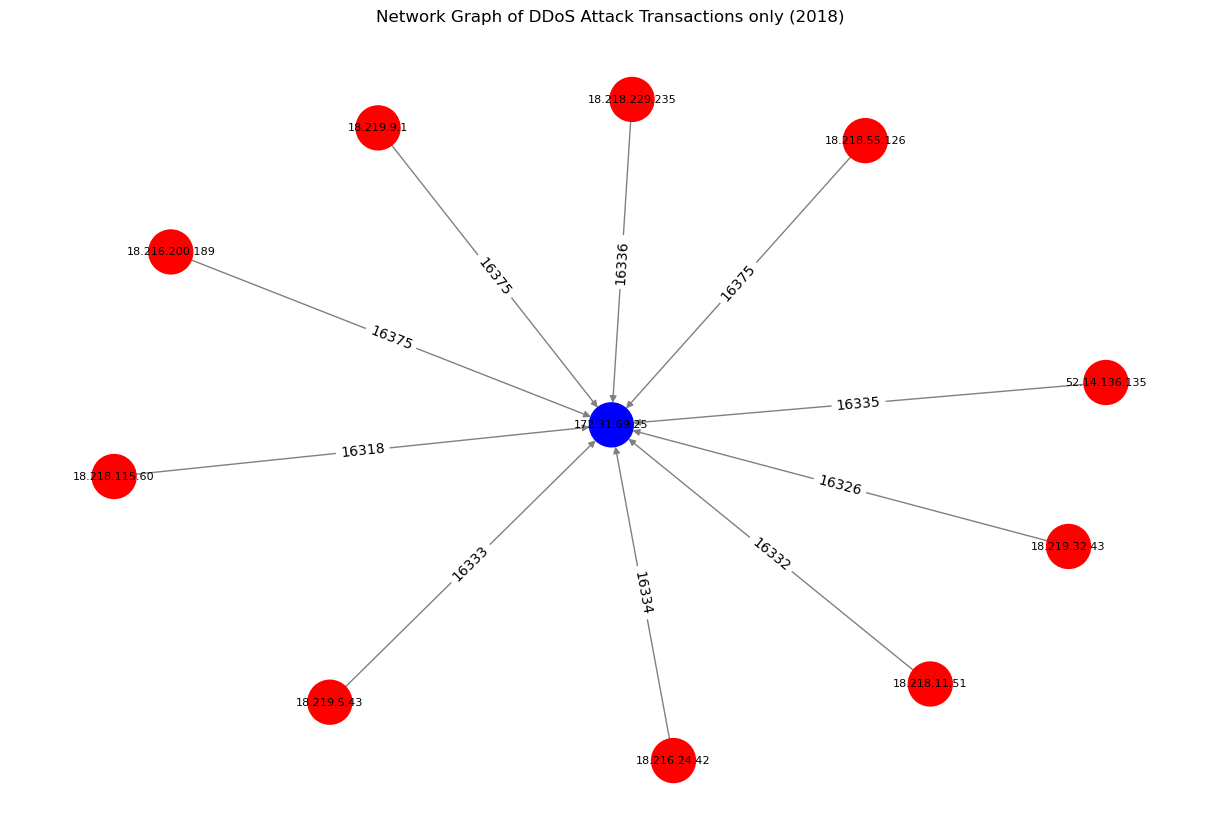

In [12]:
analysis_df = ddos2018_df_cleaned.copy()

# Filter rows where attack happened (between 10:00 and 12:00) and Label is 'DDoS attacks-LOIC-HTTP'
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'DDoS attacks-LOIC-HTTP')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
# Create a network graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of DDoS Attack Transactions only (2018)")
plt.show()

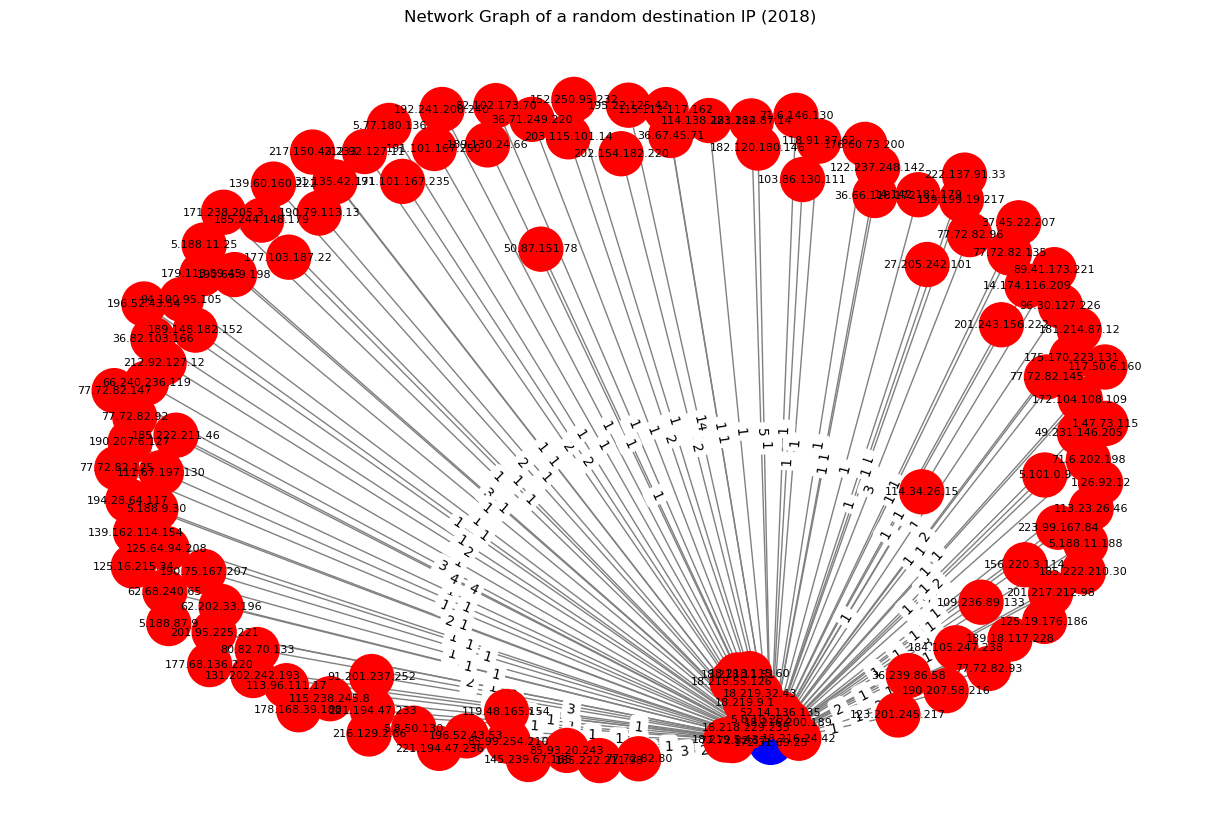

In [13]:
analysis_df = ddos2018_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Destination IP'] == '172.31.69.25')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=3, scale=6)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of a random destination IP (2018)")
plt.show()

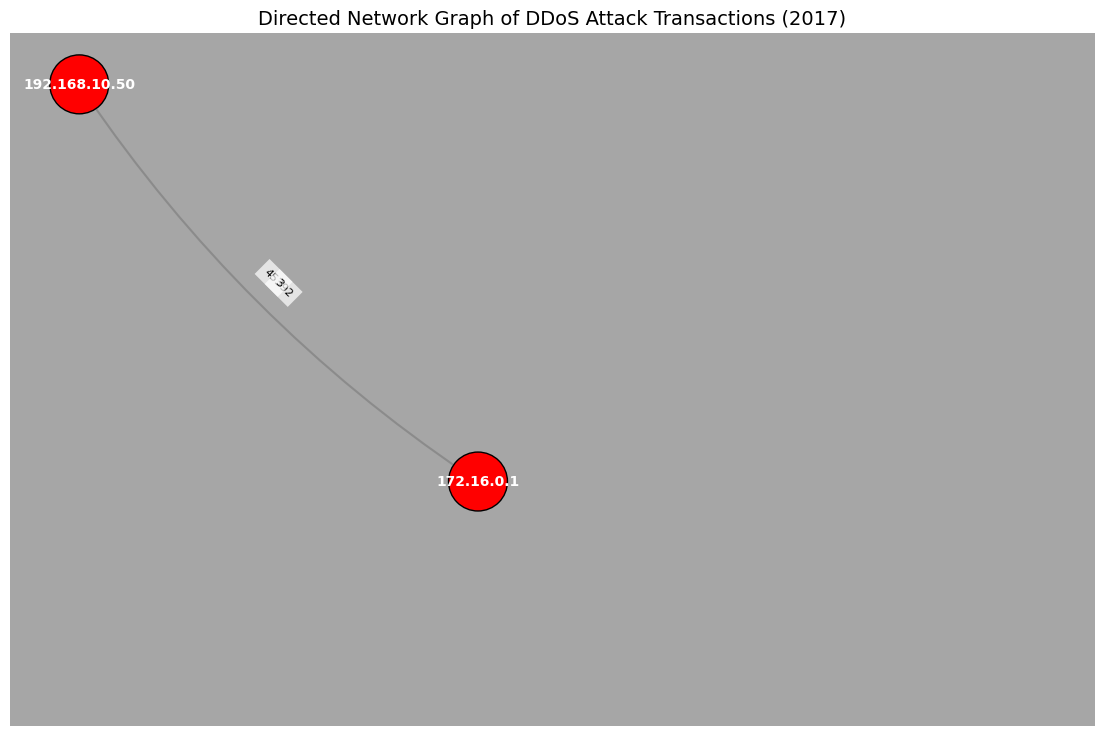

In [14]:
analysis_df = ddos2017_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'DDoS')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]

# Create a directed graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert 'weight' set to its length (number of unique flow IDs)
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (Red for sources, Blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Adjust layout to space out nodes
pos = nx.spring_layout(G, k=2, iterations=100, scale=5)  # Higher k spreads nodes apart

plt.figure(figsize=(14, 9), facecolor="white")

# Draw nodes with black edges
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color=node_colors, edgecolors='black')

# Draw directed edges with visible arrows
edge_weights = [G[u][v]['weight'] / 2 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=edge_weights,
                       arrowstyle='-|>', arrows=True, arrowsize=15, connectionstyle="arc3,rad=0.1")

# Draw node labels (White for better contrast)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="white")

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="black",
                             bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))

plt.title("Directed Network Graph of DDoS Attack Transactions (2017)", fontsize=14)
plt.axis("off")  # Hide axes
plt.show()


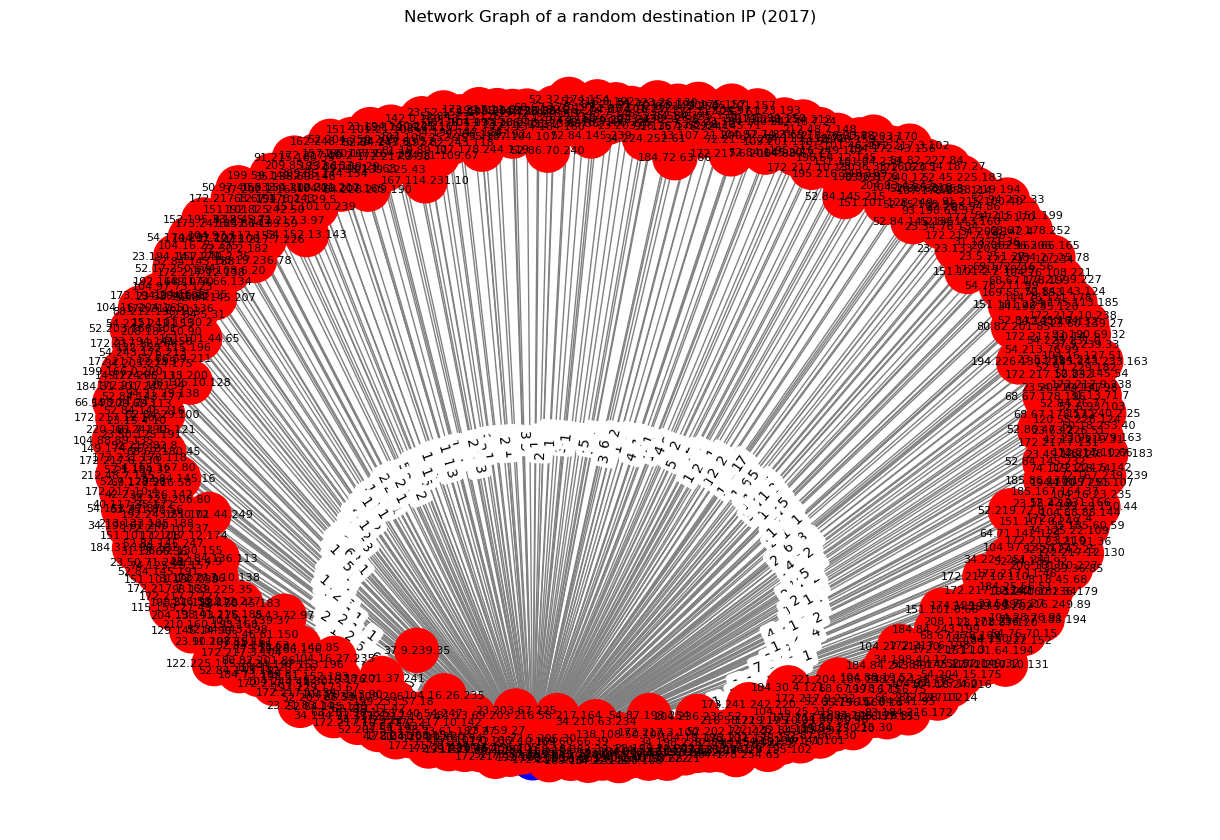

In [15]:
analysis_df = ddos2017_df_cleaned.copy()

# Filter rows to a random benign Destination IP
analysis_df_filtered = analysis_df[
    (analysis_df['Destination IP'] == '192.168.10.5')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=3, scale=6)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of a random destination IP (2017)")
plt.show()

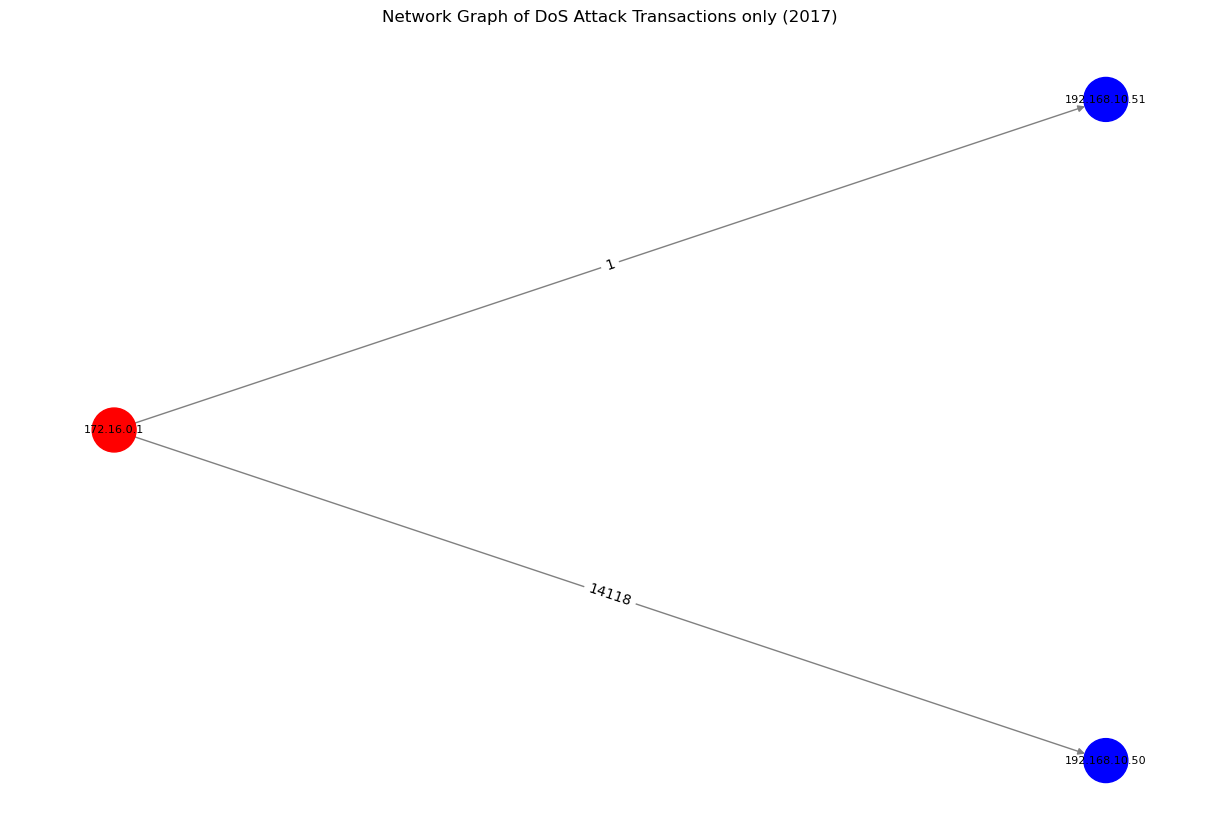

In [16]:
analysis_df = dos2017_df_cleaned.copy()
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'DOS')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
# Create a network graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of DoS Attack Transactions only (2017)")
plt.show()

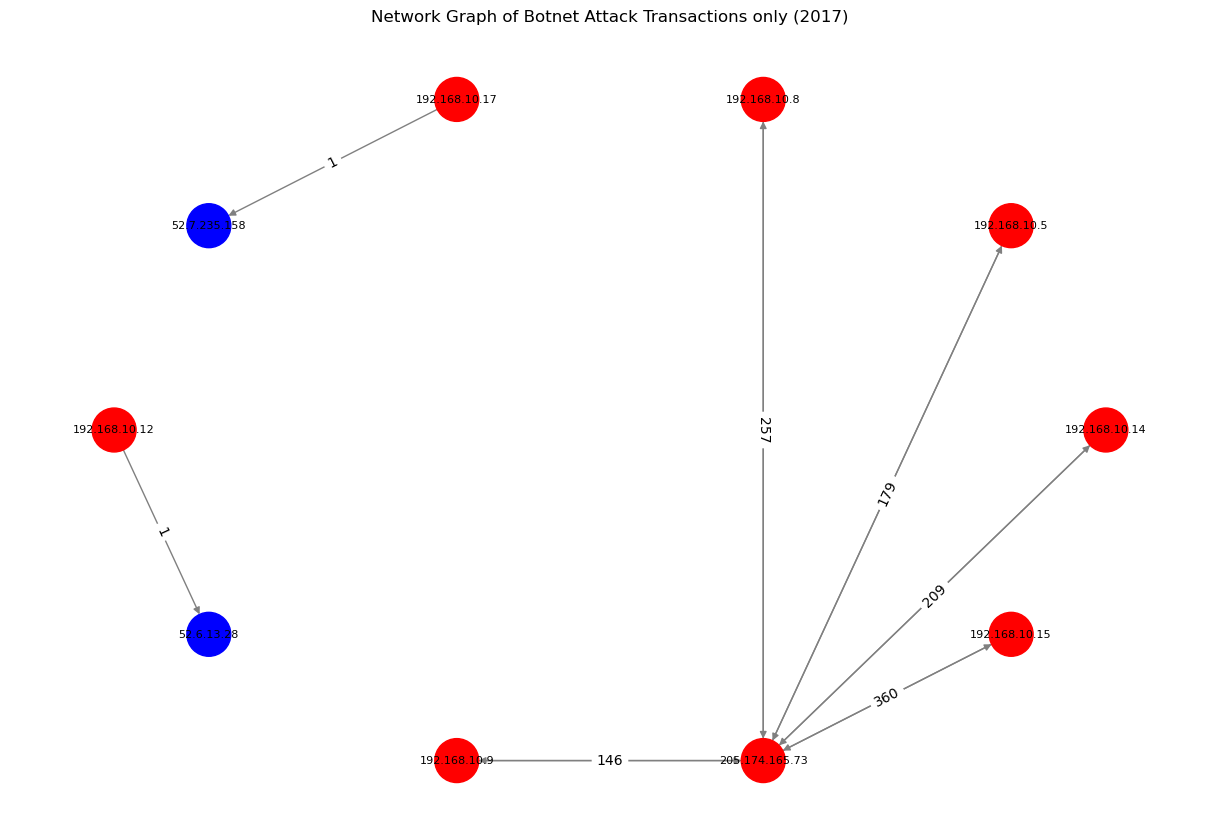

In [17]:
analysis_df = botnet2017_df_cleaned.copy()
analysis_df_filtered = analysis_df[
    (analysis_df['Label'] == 'Bot')
]
analysis_df_filtered = analysis_df_filtered[['Source IP', 'Destination IP', 'Flow ID']]
# Create a network graph
G = nx.DiGraph()

# Add edges with weight as the number of unique flow IDs
for _, row in analysis_df_filtered.iterrows():
    src, dst, flow_id = row['Source IP'], row['Destination IP'], row['Flow ID']
    if G.has_edge(src, dst):
        G[src][dst]['weight'].add(flow_id)
    else:
        G.add_edge(src, dst, weight={flow_id})

# Convert the 'weight' set to its length for final visualization
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['weight'])  # Set weight to the number of unique flow IDs

# Get unique nodes
src_ips = set(analysis_df_filtered['Source IP'])
dst_ips = set(analysis_df_filtered['Destination IP'])

# Assign colors (e.g., red for sources, blue for destinations)
node_colors = ['red' if node in src_ips else 'blue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G)  # Positioning for better visualization

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray", font_size=8, arrows=True)

# Draw edge weights (unique flow IDs)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the network graph
plt.title("Network Graph of Botnet Attack Transactions only (2017)")
plt.show()